# HDF5 Virtual Dataset Demo

HDF5 Virtual Datasets are a feature of the HDF5 library that allows to create virtual aggregations of datasets by merging the contents of multiple HDF5 files.

Since netCDF4 files are valid HDF5 files, we can reuse this feature to create virtual views of our datasets that are commonly spread between several files.

We are going to see an example using ESGF data. We will download several files from ESGF and then we will generate two virtual datasets with different levels of aggregation, in order to analyze it with xarray and show the advantages of "data analysis ready" datasets.

## Data download

We are going to download some files from ESGF in order to produce virtual aggregations over real data.

In [1]:
import os
import requests
import tqdm

In [2]:
datasets = [
    # r1i1p1f1
    "http://esgf-data3.ceda.ac.uk/thredds/fileServer/esg_cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r1i1p1f1/Amon/pr/gn/v20190914/pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-201812.nc",
    "http://esgf-data3.ceda.ac.uk/thredds/fileServer/esg_cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r1i1p1f1/Amon/pr/gn/v20190914/pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201901-202912.nc",
    "http://esgf-data3.ceda.ac.uk/thredds/fileServer/esg_cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r1i1p1f1/Amon/tas/gn/v20190914/tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-201812.nc",
    "http://esgf-data3.ceda.ac.uk/thredds/fileServer/esg_cmip6/CMIP6/CMIP/NCC/NorCPM1/historical/r1i1p1f1/Amon/tas/gn/v20190914/tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201901-202912.nc",
    
    # r2i1p1f1
    "http://noresg.nird.sigma2.no/thredds/fileServer/esg_dataroot/cmor/CMIP6/CMIP/NCC/NorCPM1/historical/r2i1p1f1/Amon/pr/gn/v20190914/pr_Amon_NorCPM1_historical_r2i1p1f1_gn_201501-201812.nc",
    "http://noresg.nird.sigma2.no/thredds/fileServer/esg_dataroot/cmor/CMIP6/CMIP/NCC/NorCPM1/historical/r2i1p1f1/Amon/pr/gn/v20190914/pr_Amon_NorCPM1_historical_r2i1p1f1_gn_201901-202912.nc",
    "http://noresg.nird.sigma2.no/thredds/fileServer/esg_dataroot/cmor/CMIP6/CMIP/NCC/NorCPM1/historical/r2i1p1f1/Amon/tas/gn/v20190914/tas_Amon_NorCPM1_historical_r2i1p1f1_gn_201501-201812.nc",
    "http://noresg.nird.sigma2.no/thredds/fileServer/esg_dataroot/cmor/CMIP6/CMIP/NCC/NorCPM1/historical/r2i1p1f1/Amon/tas/gn/v20190914/tas_Amon_NorCPM1_historical_r2i1p1f1_gn_201901-202912.nc",
]

for dataset in tqdm.tqdm(datasets):
    filename = dataset.split("/")[-1]
    if not os.path.isfile(filename):
        with requests.get(dataset, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192): 
                    f.write(chunk)

100%|██████████| 8/8 [00:00<00:00, 12018.06it/s]


## Virtual dataset creation

In order to create the virtual dataset, we need to extract information from the source files. We are going to generate a Pandas dataframe to store and later query this information.

In [3]:
import os
import re

import pandas as pd
import netCDF4
import h5py

Here we define the function that extracts information from netCDF source files.

In [4]:
def extract(f, drs):
    yield [f, None, None, None, "size", int(os.stat(f).st_size), None, None]
    with netCDF4.Dataset(f) as ds:
        if drs is not None:
            p = re.compile(drs)
            matches = p.search(f)
            for match in matches.groupdict():
                yield [f, match, matches.groupdict()[match], None, None, None, None, None]

        for dimension in ds.dimensions:
            yield [f, None, None, None, None, None, dimension, ds.dimensions[dimension].size]

        for variable in ds.variables:
            yield [f, None, None, variable, "__dtype__", str(ds.variables[variable].dtype), None, None]

            for dimension in ds.variables[variable].dimensions:
                yield [f, None, None, variable, None, None, dimension, ds.dimensions[dimension].size]

### Time series and variable aggregation

Now that we have defined our read function, we generate our DataFrame from the netCDF source files that we have downloaded.

In [5]:
sources = [os.path.basename(x) for x in datasets if "r1i1p1f1" in x]
DRS = "(?P<DRS_variableid>[^_]+)_Amon_NorCPM1_historical_(?P<DRS_variant_label>[^_]+)_gn_(?P<DRS_from>[0-9]+)-(?P<DRS_to>[0-9]+)\.nc"
columns = ["filename", "facet", "facet_value", "variable", "attr", "attr_value", "dimension", "dimension_size"]

df = pd.DataFrame([row for source in sources for row in extract(source, DRS)], columns=columns)

The DataFrame provides us with the necessary information (dimensions, dimension sizes, variable names, etc.) that we need to create the aggregation or virtual dataset.

In [6]:
df

,filename,facet,facet_value,variable,attr,attr_value,dimension,dimension_size
0,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,None,None,None,size,2143902,None,NaN
1,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_variableid,pr,None,None,None,None,NaN
2,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_variant_label,r1i1p1f1,None,None,None,None,NaN
3,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_from,201501,None,None,None,None,NaN
4,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_to,201812,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...
109,tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201901...,None,None,height,__dtype__,float64,None,NaN
110,tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201901...,None,None,tas,__dtype__,float32,None,NaN
111,tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201901...,None,None,tas,None,None,time,132.0
112,tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201901...,None,None,tas,None,None,lat,96.0


We are declaring here some helper functions that will help us when creating the virtual dataset.

In [7]:
NOT_A_VAR = "This is a netCDF dimension but not a netCDF variable.    "

def copy_attrs(src, dest, ignore=None):
    if ignore is None:
        ignore = tuple()

    for attr in src.ncattrs():
        if attr.startswith("_") or (attr in ignore): # ignore this attribute
            continue

        attr_value = src.getncattr(attr)
        if isinstance(attr_value, str):
            l = max(1,len(attr_value)) # control empty strings
            dest.attrs.create(attr, attr_value, dtype="S"+str(l))
        else:
            dest.attrs.create(attr, attr_value, dtype=attr_value.dtype)

def virtual_variable(src, dest, name):
    shape = tuple([src.dimensions[d].size for d in src.dimensions if d in src.variables[name].dimensions])
    layout = h5py.VirtualLayout(
        shape=shape,
        dtype=src.variables[name].dtype)
    vsource = h5py.VirtualSource(src.filepath(), name, shape=shape)
    layout[:] = vsource
    dest.create_virtual_dataset(name, layout)
    copy_attrs(src.variables[name], dest[name])
    
    # is coordinate?
    if len(src.variables[name].dimensions) == 1 and src.variables[name].dimensions[0] == name:
        dest[name].make_scale(name)
    
def create_dimension(group, name, size):
    name_attr = NOT_A_VAR + name
    group.create_dataset(name, size)
    group[name].make_scale(name)
    group[name].attrs.create("NAME", name, dtype="S"+str(len(name_attr)))
    
def variables_shapes(df):
    return df.dropna(axis=0, subset=["filename", "variable", "dimension", "dimension_size"])[["filename", "variable", "dimension", "dimension_size"]]

def variable_shape(df, variable):
    return variables_shapes(df[df["variable"] == variable])

def facets(df):
    facets = df.dropna(axis=0, subset=["facet", "facet_value"])[["filename", "facet", "facet_value"]]
    pivot = facets.pivot("filename", "facet", "facet_value")
    
    return pivot

def varinfo(df, variable):
    return variable_shape(df, variable).merge(facets(df), left_on="filename", right_index=True)

def join_existing(layout, df, dim, outdims=None):
    if outdims is None:
        outdims = list()

    inner_dimensions_df = df[~df["dimension"].isna()][["dimension", "dimension_size"]].drop_duplicates(subset=["dimension"]).iloc[1:]
    inner_dimensions    = dict(zip(inner_dimensions_df["dimension"], inner_dimensions_df["dimension_size"].astype(int)))
    indims    = [slice(0,x,1) for x in list(inner_dimensions.values())]

    counter = 0
    for _,row in df[df["dimension"] == dim].iterrows():
        agg_dim_size = int(row["dimension_size"])
        source_shape = tuple([agg_dim_size] + list(inner_dimensions.values()))
        vsource = h5py.VirtualSource(
            row["filename"],
            row["variable"],
            source_shape)

        if len(outdims) == 0 and len(indims) == 0:
            layout[counter:counter+agg_dim_size] = vsource
        elif len(indims) == 0:
            layout[outdims, counter:counter+agg_dim_size] = vsource
        elif len(outdims) == 0:
            layout[counter:counter+agg_dim_size, :] = vsource
        else:
            layout[outdims, counter:counter+agg_dim_size, :] = vsource

        counter += agg_dim_size
        
# Get layouts for coordinate with bounds
def layout_for_bnds_coord(coord, shape, dtype_coord, dtype_bnds):
    coord_layout = h5py.VirtualLayout(shape=shape, dtype=dtype_coord)
    
    bnds_shape = tuple(list(shape) + [2])
    bnds_layout = h5py.VirtualLayout(shape=bnds_shape, dtype=dtype_bnds)
    
    return coord_layout, bnds_layout

In [8]:
fname = "variable_aggregation.h5"

with h5py.File(fname, "w") as f:
    aggregation_variables = df[df["facet"] == "DRS_variableid"]["facet_value"].dropna().unique()

    # choose a prototype file
    prototype = netCDF4.Dataset(df["filename"].dropna().iloc[0])

    # set bounds dimension
    create_dimension(f, "bnds", 2)

    # generate "static" virtual variables
    for variable in ["lat", "lat_bnds", "lon", "lon_bnds"]:
        virtual_variable(prototype, f, variable)

    # generate the join existing coordinates
    time_len = int(varinfo(df, "time").drop_duplicates("DRS_from")["dimension_size"].sum())
    layout_time, layout_bnds = layout_for_bnds_coord(
        "time",
        (time_len,),
        df[(df["variable"] == "time") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0],
        df[(df["variable"] == "time_bnds") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0])

    join_existing(
        layout_time, 
        varinfo(df, "time").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    join_existing(
        layout_bnds,
        varinfo(df, "time_bnds").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    f.create_virtual_dataset("time",layout_time)
    f.create_virtual_dataset("time_bnds",layout_bnds)
    f["time"].make_scale("time")

    # generate aggregated variables, along with coordinates
    for variable in aggregation_variables:
        vdf = variable_shape(df, "tas").merge(facets(df), left_on="filename", right_index=True)
        variable_prototype = netCDF4.Dataset(df[(df["facet"] == "DRS_variableid") & (df["facet_value"] == variable)]["filename"].iloc[0])

        # create the virtual layout
        layout = h5py.VirtualLayout(
            shape=tuple(
                [vdf[vdf["dimension"] == "time"].drop_duplicates("DRS_from")["dimension_size"].sum()] + # time
                list(vdf[["dimension", "dimension_size"]].drop_duplicates(subset="dimension").iloc[1:]["dimension_size"])), # lat lon
            dtype=variable_prototype.variables[variable].dtype)

        join_existing(
            layout,
            varinfo(df, variable),
            "time")

        # create virtual variable
        dset = f.create_virtual_dataset(variable,layout)
        copy_attrs(variable_prototype.variables[variable], dset)
        copy_attrs(variable_prototype.variables["time"], f["time"])
        copy_attrs(variable_prototype.variables["time_bnds"], f["time_bnds"])

        # dimension scales
        dset.dims[0].attach_scale(f["time"])
        dset.dims[1].attach_scale(f["lat"])
        dset.dims[2].attach_scale(f["lon"])

        # close
        variable_prototype.close()

    prototype.close()

In [9]:
size = os.stat(fname).st_size
print("Virtual dataset size: {} bytes (~ {} KiB).".format(size, size // 1024))

Virtual dataset size: 11672 bytes (~ 11 KiB).


In [10]:
!ncdump -hs variable_aggregation.h5

netcdf variable_aggregation {
dimensions:
	bnds = 2 ;
	lat = 96 ;
	lon = 144 ;
	time = 180 ;
variables:
	float bnds(bnds) ;
		bnds:_Storage = "contiguous" ;
		bnds:_Endianness = "little" ;
		bnds:_NoFill = "true" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "unknown" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "unknown" ;
		lat_bnds:_Endianness = "little" ;
		lat_bnds:_NoFill = "true" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "unknown" ;
		lon:_Endianness = "little" ;
		lon:_NoFill = "true" ;
	double lon_bnds(lon, bnds) ;
		lon_bnds:_Storage = "unknown" ;
		lon_bnds:_Endianness = "little" ;
		lon_bnds:_NoFill = "true" ;
	float pr(time, lat, lon) 

### Variant label aggregation

In [11]:
sources = [os.path.basename(x) for x in datasets]

DRS = "(?P<DRS_variableid>[^_]+)_Amon_NorCPM1_historical_(?P<DRS_variant_label>[^_]+)_gn_(?P<DRS_from>[0-9]+)-(?P<DRS_to>[0-9]+)\.nc"
columns = ["filename", "facet", "facet_value", "variable", "attr", "attr_value", "dimension", "dimension_size"]

df = pd.DataFrame([row for source in sources for row in extract(source, DRS)], columns=columns)

In [12]:
df

,filename,facet,facet_value,variable,attr,attr_value,dimension,dimension_size
0,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,None,None,None,size,2143902,None,NaN
1,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_variableid,pr,None,None,None,None,NaN
2,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_variant_label,r1i1p1f1,None,None,None,None,NaN
3,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_from,201501,None,None,None,None,NaN
4,pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-...,DRS_to,201812,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...
223,tas_Amon_NorCPM1_historical_r2i1p1f1_gn_201901...,None,None,height,__dtype__,float64,None,NaN
224,tas_Amon_NorCPM1_historical_r2i1p1f1_gn_201901...,None,None,tas,__dtype__,float32,None,NaN
225,tas_Amon_NorCPM1_historical_r2i1p1f1_gn_201901...,None,None,tas,None,None,time,132.0
226,tas_Amon_NorCPM1_historical_r2i1p1f1_gn_201901...,None,None,tas,None,None,lat,96.0


In [13]:
fname = "ensemble_aggregation.h5"

with h5py.File(fname, "w") as f:
    aggregation_variables = df[df["facet"] == "DRS_variableid"]["facet_value"].dropna().unique()

    # variant_labels is now a dataset
    variant_labels = df[df["facet"] == "DRS_variant_label"]["facet_value"].dropna().unique()
    variant_label_dset = f.create_dataset(
        "variant_label",
        len(variant_labels),
        dtype=h5py.string_dtype("utf-8", None),
        chunks=True,
        compression="gzip")
    variant_label_dset.attrs.create("_CoordinateAxisType", "Ensemble")
    variant_label_dset.attrs.create("standard_name", "realization")
    variant_label_dset.make_scale(variant_label_dset.name)
    variant_label_dset[:] = list(variant_labels)

    # choose a prototype file
    prototype = netCDF4.Dataset(df["filename"].dropna().iloc[0])

    # set bounds dimension
    create_dimension(f, "bnds", 2)

    # generate "static" virtual variables
    for variable in ["lat", "lat_bnds", "lon", "lon_bnds"]:
        virtual_variable(prototype, f, variable)

    # generate the join existing coordinates
    time_len = int(varinfo(df, "time").drop_duplicates("DRS_from")["dimension_size"].sum())
    layout_time, layout_bnds = layout_for_bnds_coord(
        "time",
        (time_len,),
        df[(df["variable"] == "time") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0],
        df[(df["variable"] == "time_bnds") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0])

    join_existing(
        layout_time, 
        varinfo(df, "time").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    join_existing(
        layout_bnds,
        varinfo(df, "time_bnds").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    f.create_virtual_dataset("time",layout_time)
    f.create_virtual_dataset("time_bnds",layout_bnds)
    f["time"].make_scale("time")

    # generate aggregated variables, along with coordinates
    for variable in aggregation_variables:
        vdf = variable_shape(df, "tas").merge(facets(df), left_on="filename", right_index=True)
        variable_prototype = netCDF4.Dataset(df[(df["facet"] == "DRS_variableid") & (df["facet_value"] == variable)]["filename"].iloc[0])

        # create the virtual layout
        layout = h5py.VirtualLayout(
            shape=tuple(
                [len(variant_labels)] + # variant_label
                [vdf[vdf["dimension"] == "time"].drop_duplicates("DRS_from")["dimension_size"].sum()] + # time
                list(vdf[["dimension", "dimension_size"]].drop_duplicates(subset="dimension").iloc[1:]["dimension_size"])), # lat lon
            dtype=variable_prototype.variables[variable].dtype)

        # fill virtual layout
        for i,variant_label in enumerate(variant_labels):
            join_existing(
                layout,
                varinfo(df, variable).query('(DRS_variant_label == "{}")'.format(variant_label)),
                "time",
                outdims=[i])

        # create virtual variable
        dset = f.create_virtual_dataset(variable, layout, fillvalue=variable_prototype.variables[variable]._FillValue)
        copy_attrs(variable_prototype.variables[variable], dset)
        copy_attrs(variable_prototype.variables["time"], f["time"])
        copy_attrs(variable_prototype.variables["time_bnds"], f["time_bnds"])

        # dimension scales
        dset.dims[0].attach_scale(f["variant_label"])
        dset.dims[1].attach_scale(f["time"])
        dset.dims[2].attach_scale(f["lat"])
        dset.dims[3].attach_scale(f["lon"])

        # close
        variable_prototype.close()

    prototype.close()

In [14]:
size = os.stat(fname).st_size
print("Virtual dataset size: {} bytes (~ {} KiB).".format(size, size // 1024))

Virtual dataset size: 15071 bytes (~ 14 KiB).


In [15]:
!ncdump -hs ensemble_aggregation.h5

netcdf ensemble_aggregation {
dimensions:
	bnds = 2 ;
	lat = 96 ;
	lon = 144 ;
	time = 180 ;
	variant_label = 2 ;
variables:
	float bnds(bnds) ;
		bnds:_Storage = "contiguous" ;
		bnds:_Endianness = "little" ;
		bnds:_NoFill = "true" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "unknown" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "unknown" ;
		lat_bnds:_Endianness = "little" ;
		lat_bnds:_NoFill = "true" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "unknown" ;
		lon:_Endianness = "little" ;
		lon:_NoFill = "true" ;
	double lon_bnds(lon, bnds) ;
		lon_bnds:_Storage = "unknown" ;
		lon_bnds:_Endianness = "little" ;
		lon_bnds:_NoFill = "true" ;
	floa

## Virtual dataset examination - xarray

In [16]:
import xarray
import matplotlib.pyplot as plt

In [17]:
def test(reference, test):
    reference_mean = reference.mean().values.item()
    test_mean      = test.mean().values.item()
    
    return reference_mean == test_mean

### Time series and variable aggregation

In [18]:
ds = xarray.open_dataset("variable_aggregation.h5")

In [19]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 144, time: 180)
Coordinates:
  * bnds       (bnds) float32 0.0 0.0
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2015-01-16 12:00:00 ... 2029-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...

In [20]:
with xarray.open_dataset("tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-201812.nc") as reference:
    print(test(reference["tas"], ds["tas"].sel(time=slice("20150101", "20181231"))))

with xarray.open_dataset("tas_Amon_NorCPM1_historical_r1i1p1f1_gn_201901-202912.nc") as reference:
    print(test(reference["tas"], ds["tas"].sel(time=slice("20190101", "20291231"))))
    
with xarray.open_dataset("pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201501-201812.nc") as reference:
    print(test(reference["pr"], ds["pr"].sel(time=slice("20150101", "20181231"))))

with xarray.open_dataset("pr_Amon_NorCPM1_historical_r1i1p1f1_gn_201901-202912.nc") as reference:
    print(test(reference["pr"], ds["pr"].sel(time=slice("20190101", "20291231"))))

True
True
True
True


In [21]:
ds.close()

### Variant label aggregation

In [22]:
ds = xarray.open_dataset("ensemble_aggregation.h5")

In [23]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 96, lon: 144, variant_label: 2, time: 180)
Coordinates:
  * bnds           (bnds) float32 0.0 0.0
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time           (time) object 2015-01-16 12:00:00 ... 2029-12-16 12:00:00
  * variant_label  (variant_label) object 'r1i1p1f1' 'r2i1p1f1'
Data variables:
    lat_bnds       (lat, bnds) float64 ...
    lon_bnds       (lon, bnds) float64 ...
    pr             (variant_label, time, lat, lon) float32 ...
    tas            (variant_label, time, lat, lon) float32 ...
    time_bnds      (time, bnds) object ...

In [24]:
for vl in ["r1i1p1f1", "r2i1p1f1"]:
    with xarray.open_dataset("tas_Amon_NorCPM1_historical_{}_gn_201501-201812.nc".format(vl)) as reference:
        print(test(reference["tas"], ds["tas"].sel(variant_label=vl, time=slice("20150101", "20181231"))))

    with xarray.open_dataset("tas_Amon_NorCPM1_historical_{}_gn_201901-202912.nc".format(vl)) as reference:
        print(test(reference["tas"], ds["tas"].sel(variant_label=vl, time=slice("20190101", "20291231"))))

    with xarray.open_dataset("pr_Amon_NorCPM1_historical_{}_gn_201501-201812.nc".format(vl)) as reference:
        print(test(reference["pr"], ds["pr"].sel(variant_label=vl, time=slice("20150101", "20181231"))))

    with xarray.open_dataset("pr_Amon_NorCPM1_historical_{}_gn_201901-202912.nc".format(vl)) as reference:
        print(test(reference["pr"], ds["pr"].sel(variant_label=vl, time=slice("20190101", "20291231"))))

True
True
True
True
True
True
True
True


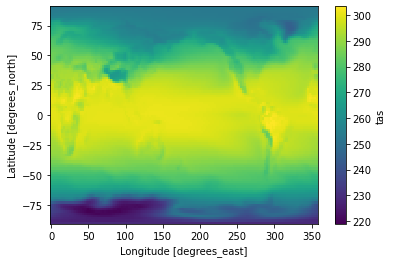

In [25]:
ds["tas"].mean(["time", "variant_label"]).plot()

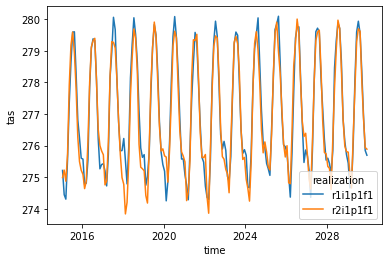

In [26]:
ds["tas"].mean(["lat", "lon"]).plot.line(x="time") # requires nc-time-axis

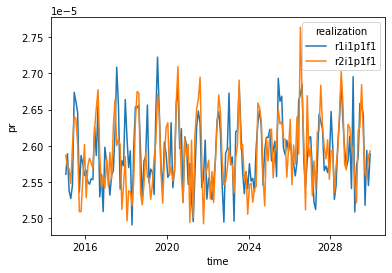

In [27]:
ds["pr"].mean(["lat", "lon"]).plot.line(x="time") # requires nc-time-axis

In [28]:
ds.close()

## Virtual dataset with NCO

## Conclusions

- HDF5 Virtual Dataset (VDS) is a powerful feature that allows to create compound virtual views of existing datasets without requiring additional storage capacity.
- Since netCDF4, netCDF datasets are also HDF5 files. Thus, netCDF applications (xarray, nco, cdo) may also benefit from the VDS feature.
- Data analysis ready datasets facilitate and optimize end user data analysis workflows.
- Creation of Virtual Datasets is a form of ETL (Extract Transform Load) process.
- netCDF client libraries may find issues when opening virtual datasets (e.g. nccopy, due to “storage mode” unknown).